<a href="https://colab.research.google.com/github/georgezefko/Recommender_System/blob/main/Exploratory%20Data%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brazilian E-Commerce Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Introduction

E-Commerce is an ever growing market and it keeps getting bigger as technology becomes a bigger part of our lives. Now the success of an online business can depend on multiple factors such as good peer reviews, a good suggestion system, and market visibility.
In the last few years, it has been proven that a good recommendation system can give sales a great boost. 

In this context we have chosen 3 main Key Performance Indicators which can help Olist to boost its business. They are,

 1.Increasing the monthly sales.

 2.Increasing the average order size.

 3.Increasing the customer lifetime value. 

In order to achieve the 1st KPI, we will focus on building a recommendation system using a primary attribute called review score which cutomers have given to the purchased products. In order to make more targeted recommendations we will try to include additional attributes such as order time and location. Also,  we will evaluate whether such a system can be applied with the data provided by Olist or not and we will provide suggestion upon that.

As a second step in the study, we will construct a graph to identify which items are connected the most. The nodes of the network will represent the products and the edges between them represent whether or not those two products were included in the same order. The graph will be simple, meaning that it will be undirected and with no self-loops. We are planning to generate and visualize the network using the networkx library. Through this approach we would expect to identify the average order size of the products in order to increase the average size of the order as the second KPI.

At last we will perform text analysis on the reviews in order to investigate hidden topics in the text that can provide information about customers' satisfaction as well as Olist service efficiency. This will be a good measure to identify the satisfaction of the retained customers & how to detect whether any actions should be taken from Olist in order to meet customer expectations. For example, to focus on improving their delivery system. This will indirectly achieve olist third KPI which is the increment of customer lifetime value.


In the present notebook a preliminary exploratory analysis is depicted. For further analysis such as building recommendation systems, text analysis are depicted on the corresponding notebooks.
 


#Data

In [ ]:
#import the datasets


path = '/content/drive/MyDrive/AdvancedBA/Olie_data/archive' #adjust this one to yours
#path ='/content/drive/MyDrive/olist_project'
customers = pd.read_csv(path +'/olist_customers_dataset.csv')
reviews = pd.read_csv(path+'/olist_order_reviews_dataset.csv')
geolocation = pd.read_csv(path+'/olist_geolocation_dataset.csv')
items = pd.read_csv(path + '/olist_order_items_dataset.csv')
payments  = pd.read_csv(path + '/olist_order_payments_dataset.csv')
orders= pd.read_csv(path + '/olist_orders_dataset.csv')
products = pd.read_csv(path + '/olist_products_dataset.csv')
sellers =pd.read_csv(path + '/olist_sellers_dataset.csv')
category =  pd.read_csv(path + '/product_category_name_translation.csv')

The figure below illustrates the connection among the datasets.

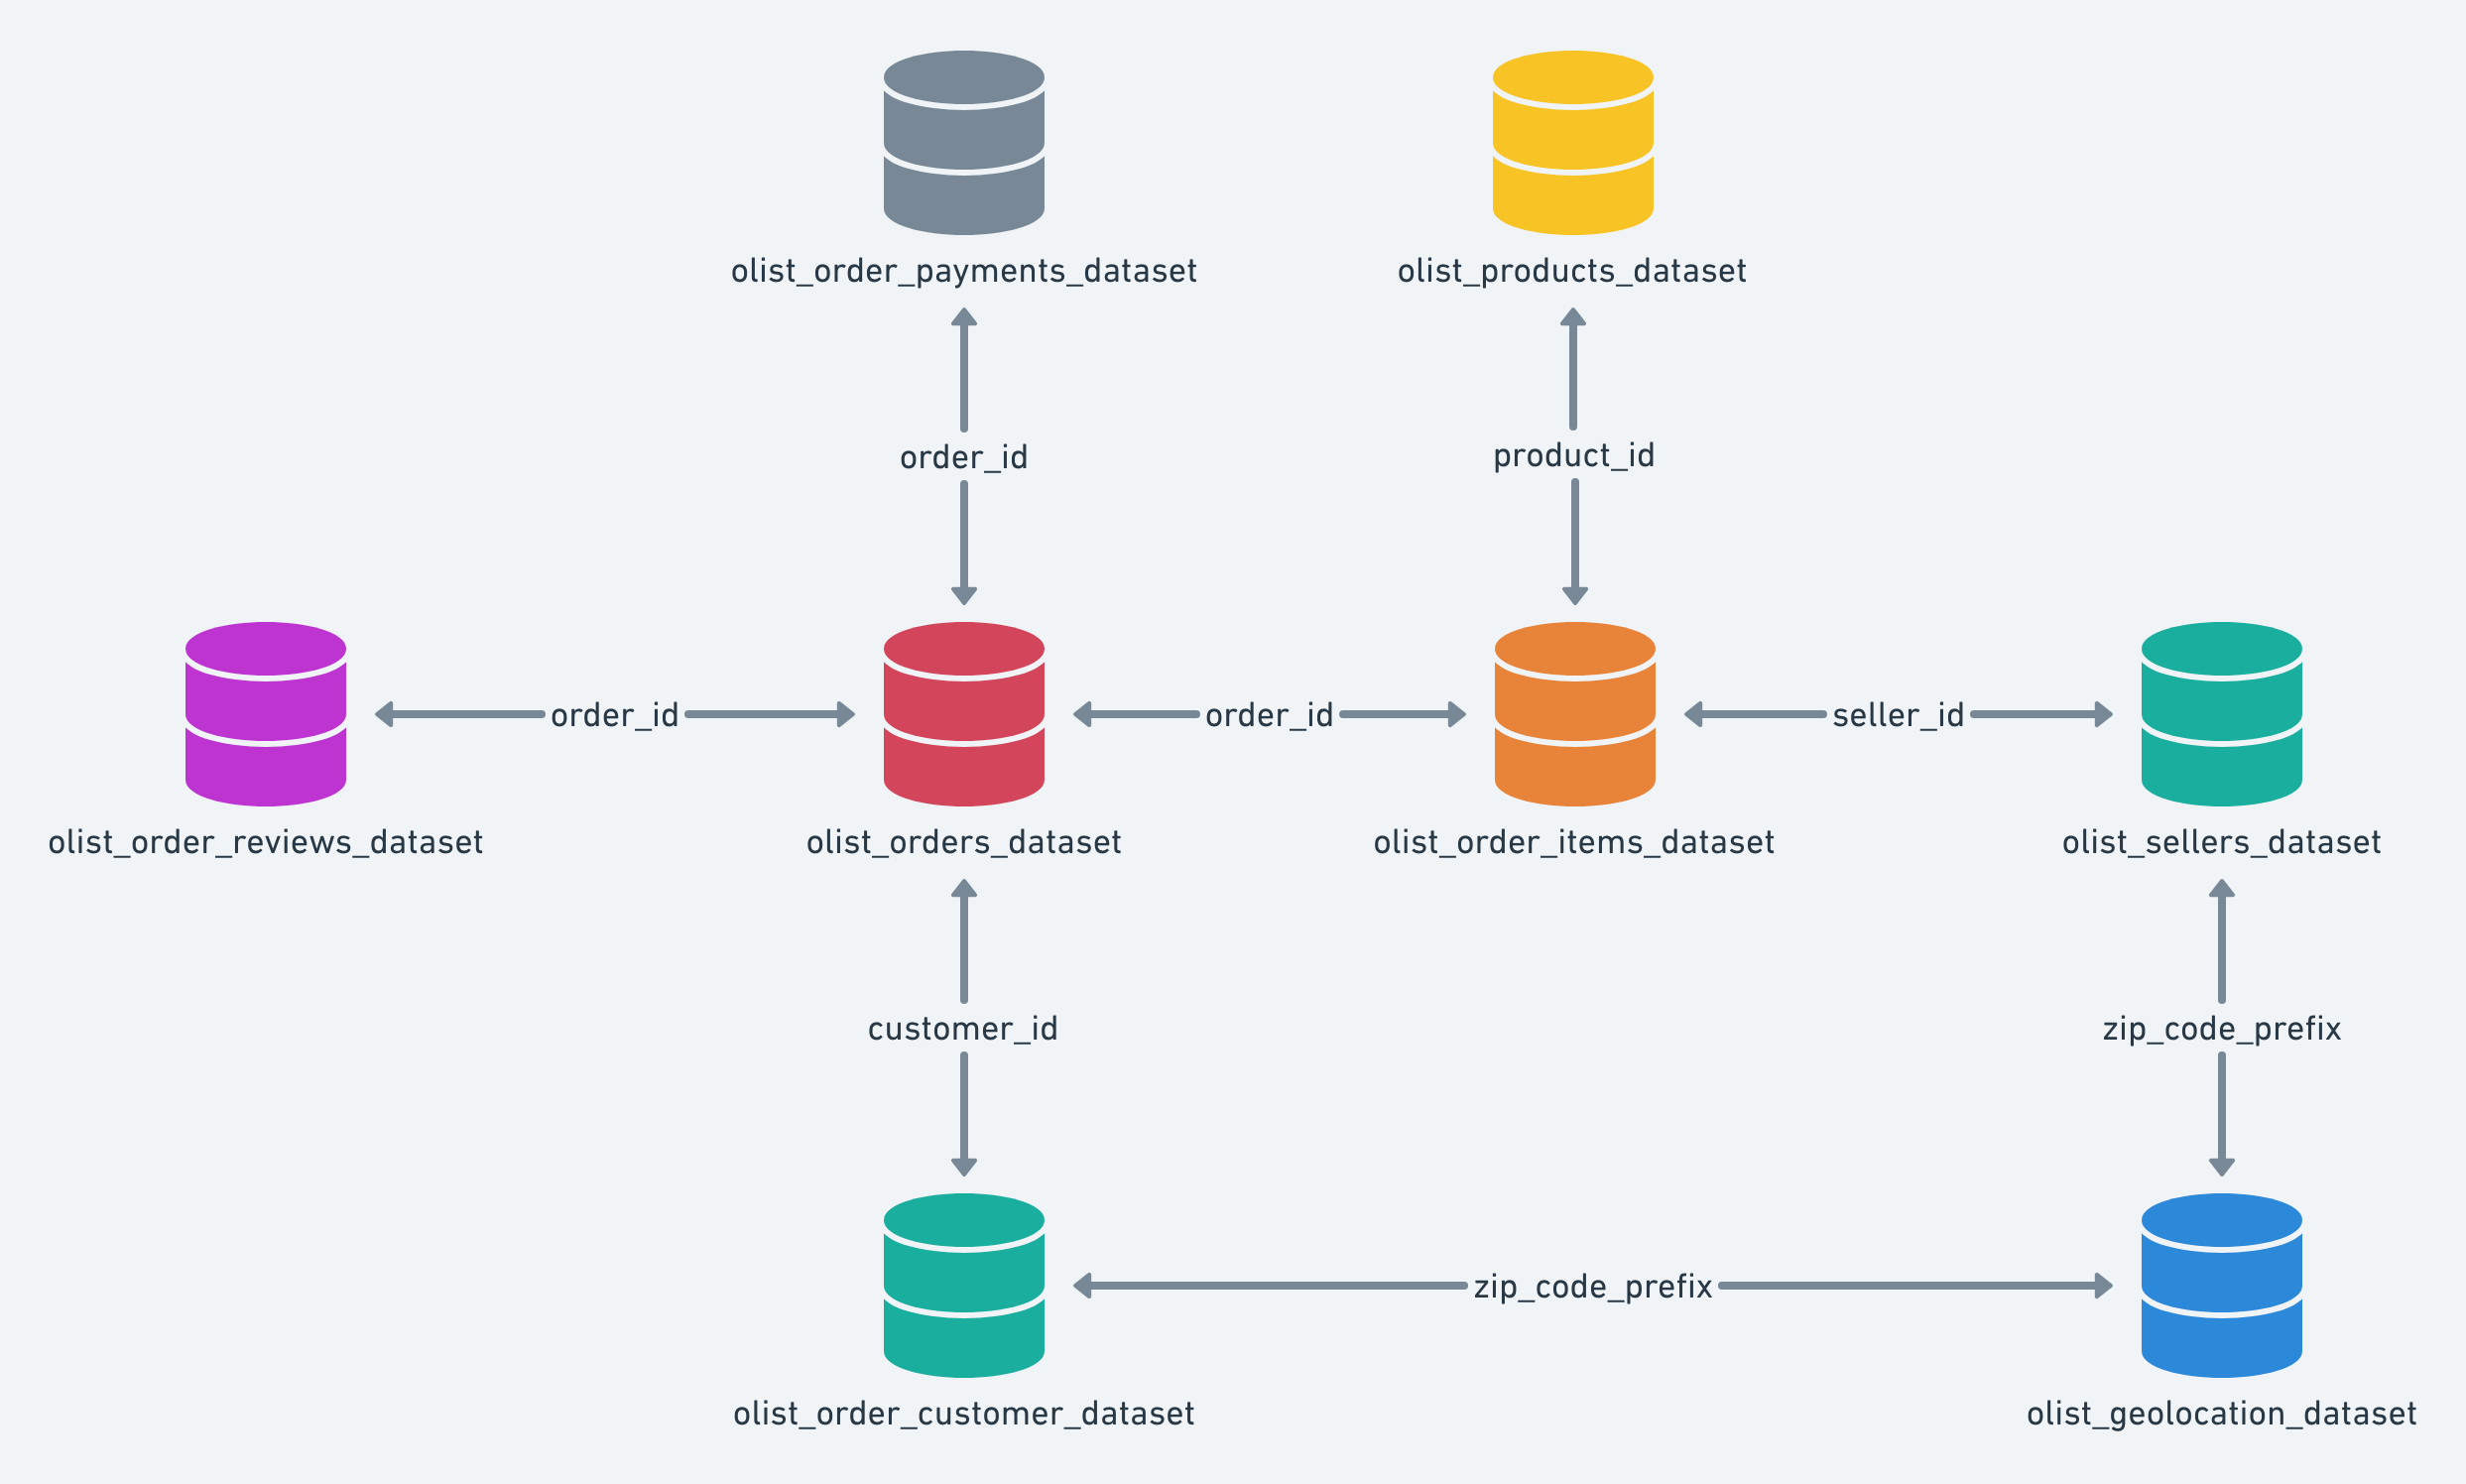

In [ ]:

print('The shape and volume for each dataset is shown below')
print('The customers dataset',customers.shape) 
print('The reviews dataset',reviews.shape)
print('The geolocation dataset',geolocation.shape)
print('The items dataset',items.shape)
print('The payments dataset',payments.shape)
print('The orders dataset',orders.shape)
print('The products dataset',products.shape)
print('The sellers dataset',sellers.shape)
print('The category dataset',category.shape)

The shape and volume for each dataset is shown below
The customers dataset (99441, 5)
The reviews dataset (100000, 7)
The geolocation dataset (1000163, 5)
The items dataset (112650, 7)
The payments dataset (103886, 5)
The orders dataset (99441, 8)
The products dataset (32951, 9)
The sellers dataset (3095, 4)
The category dataset (71, 2)


Due to high number of datasets and their volume only relevant to the business problem datasets will be analysed.

For the recommender system we will consider mainly the datasets contains the reviews, products, customers and orders. 

In [ ]:
data = pd.merge(orders,customers,on='customer_id')
data = pd.merge(data,reviews,on='order_id')
data = pd.merge(data,items,on='order_id')
data = pd.merge(data,products,on='product_id')
data = pd.merge(data,sellers,on='seller_id')
data = pd.merge(data, category,on ='product_category_name') # I added this one to get the tra
data.shape

(111686, 36)

In [ ]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
1,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
2,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
3,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-10-27 16:48:46,2017-11-07 18:04:59,2017-11-13 00:00:00,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1bafb430e498b939f258b9c9dbdff9b1,3,NaN,NaN,2017-11-08 00:00:00,2017-11-10 19:52:38,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350,maua,SP,housewares
4,5f49f31e537f8f1a496454b48edbe34d,a7260a6ccba78544ccfaf43f920b7240,delivered,2017-08-24 11:31:28,2017-08-24 11:45:25,2017-08-25 14:17:55,2017-08-28 20:12:20,2017-09-14 00:00:00,7a1de9bde89aedca8c5fbad489c5571c,1315,sao paulo,SP,8899ca945efd951c97107b4966289227,1,NaN,Prezados que porcaria de atendimento ao client...,2017-08-29 00:00:00,2017-08-30 02:26:02,2,be03d93320192443b8fa24c0ca6ead98,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-30 11:45:25,46.80,67.70,utilidades_domesticas,59.0,189.0,3.0,775.0,16.0,16.0,13.0,9350,maua,SP,housewares


In [ ]:
#check for null values (values shown as percentage) 
round(data.isnull().sum()/len(data)*100,2)


order_id                          0.00
customer_id                       0.00
order_status                      0.00
order_purchase_timestamp          0.00
order_approved_at                 0.01
order_delivered_carrier_date      1.04
order_delivered_customer_date     2.15
order_estimated_delivery_date     0.00
customer_unique_id                0.00
customer_zip_code_prefix          0.00
customer_city                     0.00
customer_state                    0.00
review_id                         0.00
review_score                      0.00
review_comment_title             87.88
review_comment_message           57.15
review_creation_date              0.00
review_answer_timestamp           0.00
order_item_id                     0.00
product_id                        0.00
seller_id                         0.00
shipping_limit_date               0.00
price                             0.00
freight_value                     0.00
product_category_name             0.00
product_name_lenght      

The vast majority of null values are in review_comment title and message. Thus they cannot be used for further analysis.

The amount of columns in the dataset remains large. Hence we will narrow down to the number of necessary columns in order to proceed with the data exploration.

We have decided to proceed with the following columns:

 ***Product_id*** : This column specifies the unique id for the products sold\
 ***customer_unique_id*** : This columns provided a uniqie id for all each customer\
 ***reviews_score*** : The score given by each customer to the products they purchased \
 ***order_purchase_timestamp***: When the order for a specific porudct was placed by the customer \
 ***product_category_name_english***: The categories where the products belong to, in english for better understanding \
 ***customer_state***: Where the customers are located in the country \
 ***seller_state***: Where the sellers are located in the country\
 ***Price*** : Price of the product

#Data exploration

In [ ]:
recommender = data[['review_score','customer_state','seller_state','product_id','product_category_name_english','customer_unique_id','order_purchase_timestamp','order_delivered_customer_date','price']]

In [ ]:
recommender.shape

(111686, 9)

In [ ]:
recommender.head()

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,price
0,4,SP,SP,87285b34884572647811a353c7ac498a,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99
1,4,SP,SP,87285b34884572647811a353c7ac498a,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,2017-08-15 18:29:31,2017-08-18 14:44:43,29.99
2,5,SP,SP,87285b34884572647811a353c7ac498a,housewares,ef0996a1a279c26e7ecbd737be23d235,2017-08-02 18:24:47,2017-08-07 18:30:01,29.99
3,3,SC,SP,87285b34884572647811a353c7ac498a,housewares,e781fdcc107d13d865fc7698711cc572,2017-10-23 23:26:46,2017-11-07 18:04:59,29.99
4,1,SP,SP,be03d93320192443b8fa24c0ca6ead98,housewares,7a1de9bde89aedca8c5fbad489c5571c,2017-08-24 11:31:28,2017-08-28 20:12:20,46.80


Initially, in order to better understand the product_id and customer_unique_id will convert the string to unique numbers instead.

In [ ]:
recommender = recommender.assign(customer_unique_id=(recommender['customer_unique_id']).astype('category').cat.codes)
recommender = recommender.assign(product_id=(recommender['product_id']).astype('category').cat.codes)


In [ ]:
recommender.head()

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,order_delivered_customer_date,price
0,4,SP,SP,17106,housewares,45758,2017-10-02 10:56:33,2017-10-10 21:25:13,29.99
1,4,SP,SP,17106,housewares,21530,2017-08-15 18:29:31,2017-08-18 14:44:43,29.99
2,5,SP,SP,17106,housewares,87936,2017-08-02 18:24:47,2017-08-07 18:30:01,29.99
3,3,SC,SP,17106,housewares,85228,2017-10-23 23:26:46,2017-11-07 18:04:59,29.99
4,1,SP,SP,23951,housewares,44958,2017-08-24 11:31:28,2017-08-28 20:12:20,46.80


## Reviews - Products

For first step we would like to see how the review scores are distributed

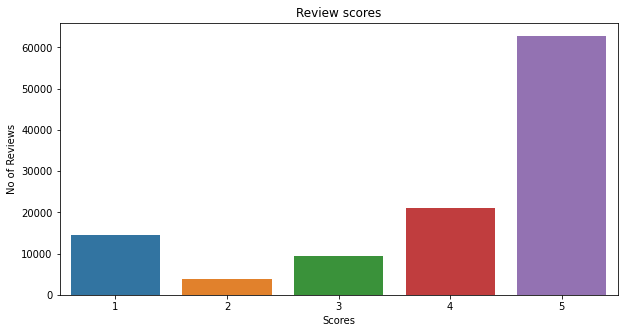

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(x=recommender['review_score'])
plt.title('Review scores')
plt.xlabel('Scores')
plt.ylabel('No of Reviews')
plt.show()

In [ ]:
scores = [1,2,3,4,5]
for i in scores:
  print('Review score:',i)
  print(round(recommender[recommender['review_score']==i].count()[0]/recommender.count()[0],2)*100)

Review score: 1
13.0
Review score: 2
4.0
Review score: 3
8.0
Review score: 4
19.0
Review score: 5
56.00000000000001


We can see that the 75% of the customers have been fully satisfied with the products and services of Olist

In [ ]:
def by_review(df,pl):
  fields = df.columns.tolist()
  colors = ['#1D2F6F', '#8390FA', '#6EAF46', '#FAC748', '#7f7f7f']
  labels = ['1', '2', '3', '4','5']

  # figure and axis
  fig, ax = plt.subplots(1, figsize=(15, 15))
  # plot bars
  left = len(df) * [0]
  for idx, name in enumerate(fields):
      plt.barh(df.index, df[name], left = left, color=colors[idx])
      left = left + df[name]
  # title, legend, labels
  plt.title(df.index.name, loc='left')
  plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=5, frameon=False)
  if pl == 1:
    plt.xlabel('No of reviews')
  else:
    plt.xlabel('Days')
  # remove spines
  ax.spines['right'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.spines['top'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  # adjust limits and draw grid lines
  plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
  ax.set_axisbelow(True)
  ax.xaxis.grid(color='gray', linestyle='dashed')
  plt.show()

In [ ]:
df_products = recommender.groupby(['product_category_name_english', 'review_score']).size().unstack()
#df_products.fillna(0,inplace=True)
df_products = df_products.fillna(0).sort_values(df_products.columns.tolist()[3], ascending=True)

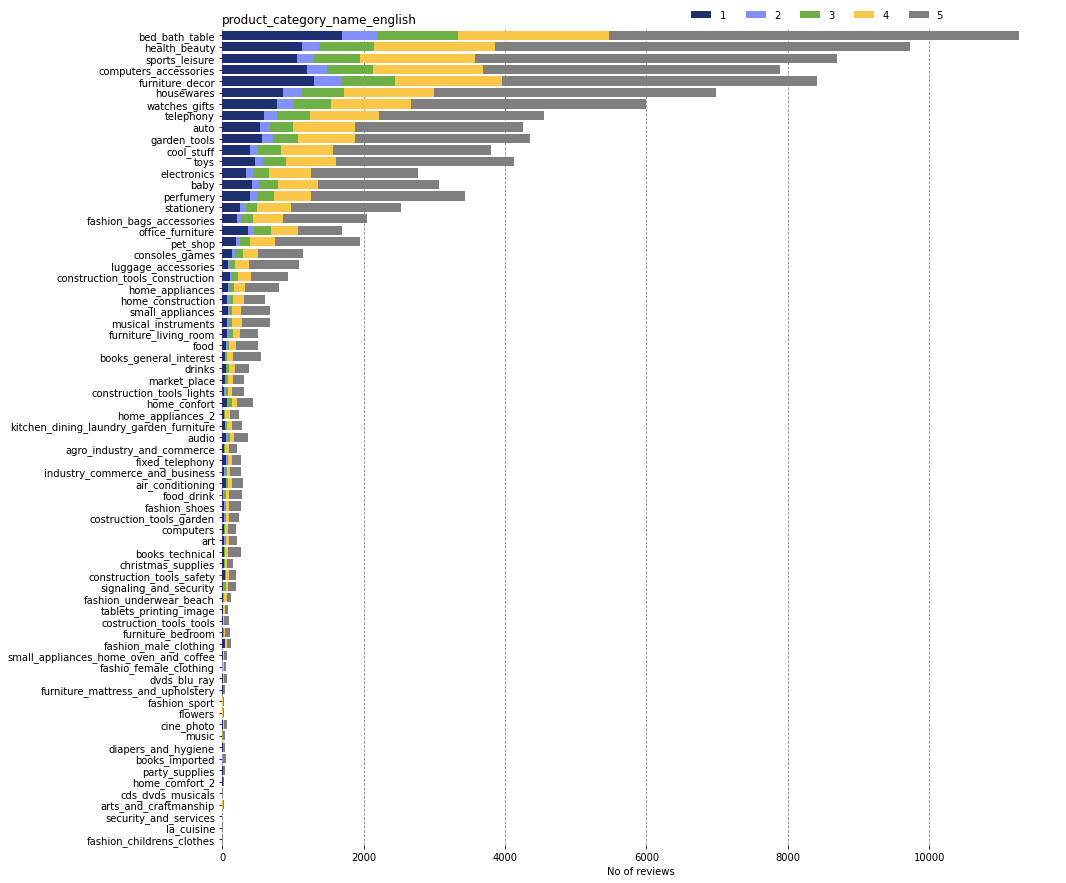

In [ ]:
by_review(df_products,1)

From the plot above, we observe that the most popular products falls into the categories:\
 bed_bath_table, 
 health and beauty\
 sports_leisure\
 Furniture_decor

 We won't show how the product_ids are distributed in each category  due to high volume of unique product ids

In [ ]:
#product_ids
len(recommender['product_id'].unique())

32328

In [ ]:
df_products_id = recommender.groupby(['product_id','product_category_name_english' ]).size().unstack()
df_products_id.fillna(0,inplace=True)
df_products_id = df_products_id[['bed_bath_table','health_beauty','sports_leisure','furniture_decor']]
df_products_id = df_products_id.sort_values(df_products_id.columns.tolist()[3], ascending=True)

In [ ]:
round((len(df_products_id.loc[(df_products_id!=0).any(axis=1)])/len(recommender['product_id'].unique()))*100,2)

34.02

However, we can see that 34.02% of all the products belong to the top four categories.

In [ ]:
recommender['order_purchase_timestamp'] = pd.to_datetime(recommender['order_purchase_timestamp'],errors='coerce')

recommender['order_date'] = recommender['order_purchase_timestamp'].dt.date #get date

recommender['order_delivered_customer_date'] = pd.to_datetime(recommender['order_delivered_customer_date'],errors='coerce')

recommender['delivered_date'] = recommender['order_delivered_customer_date'].dt.date #get date

recommender['days_diff'] = ( recommender['delivered_date'] - recommender['order_date'] ).dt.days

In [ ]:
recommender['days_diff'] = recommender['days_diff'].fillna(0)

In [ ]:
recommender.groupby(['review_score'])['days_diff'].mean()

review_score
1    17.291396
2    15.001021
3    13.732917
4    12.087070
5    10.560216
Name: days_diff, dtype: float64

Above we can see that the longer the waiting time until the delivery the lower the review score. Below we will show which materials take longer to deliver.

In [ ]:
frame = recommender.pivot_table(index='product_category_name_english',columns='review_score', values='days_diff',aggfunc='mean')

frame = frame.sort_values(frame.columns.tolist(), ascending=True)

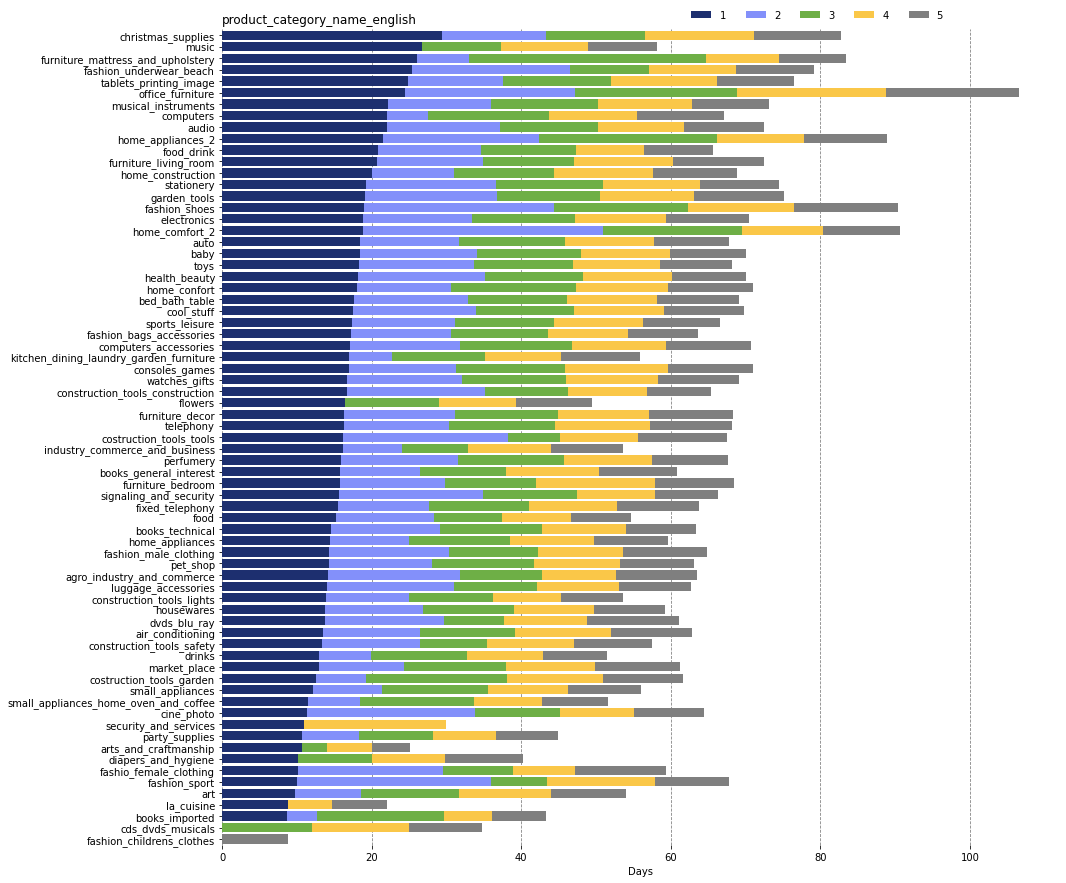

In [ ]:
by_review(frame,0)

Above we see the time difference in days from the day a customer place the order to the day the order was delivered for every category.

Looking for each categorie we observe that for some categories the longer the waiting time coresponds to a bad review indeed. For categories music and christmas supply (the first two on top) have review score 1 for waiting time equivalent to 20 days.

On the other hand for fashion_children_clothes and la_cuisine (two in the bottom) it seems that delivery time and review score doen't reflect one another. Chldren clothes get score 5 for delivery time of apporimately 10 days while la_cusine gets score 1 for the same time.





## Customers - Location - Products

We would like to see whether customers buy their products from sellers in the same location as theirs.

Below the distributions of customer and sellers per state is illustrated.

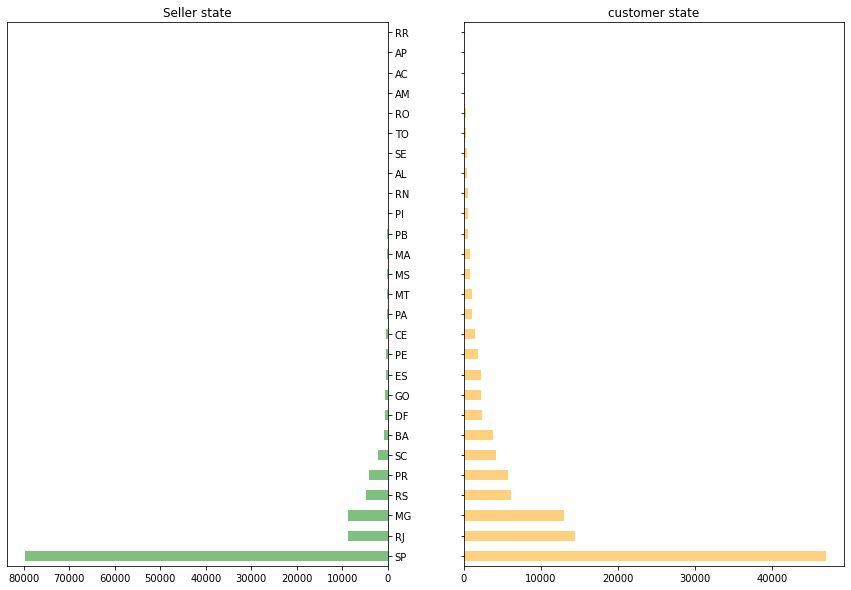

In [ ]:
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True,figsize=(15,10))

ax.invert_xaxis()
ax.yaxis.tick_right()

recommender['seller_state'].value_counts().sort_values(ascending=False).plot(kind='barh', x='LABEL',  legend=False, ax=ax,title = 'Seller state', facecolor = 'green',alpha=0.5)
recommender['customer_state'].value_counts().sort_values(ascending=False).plot(kind='barh', x='LABEL',ax=ax2, title = 'customer state',facecolor ='orange',alpha=0.5)
plt.show()

We can see that sellers and customers are equally distributed across the states.
Apart from the state of Sao Paolo (SP) where the sellers seems to out number the customers, in the rest of the states we observe the opposite case.

Below we can see the proportion seller per customer in each state. We can see that in four states no sellers exists (where NAN values are shown). Hence, the customers from those states, most likely get their products from neighbor states or online.

No further investigation will be carried out on that matter since it is not expected to affect the recommender system.

In [ ]:
recommender['seller_state'].value_counts()/recommender['customer_state'].value_counts()

AC    0.011111
AL         NaN
AM    0.018293
AP         NaN
BA    0.171634
CE    0.064164
DF    0.371250
ES    0.162150
GO    0.222367
MA    0.496333
MG    0.665541
MS    0.060827
MT    0.138623
PA    0.007491
PB    0.059022
PE    0.249443
PI    0.022388
PR    1.528232
RJ    0.328878
RN    0.106667
RO    0.051471
RR         NaN
RS    0.349499
SC    0.985950
SE    0.026110
SP    1.692914
TO         NaN
dtype: float64

Next, we will show what is the probability to purchase each product in each state (customer state).
For the sake of simplicity we will include solely top 10 product categories and customer states 

In [ ]:
focuscategories = [i for i in recommender['product_category_name_english'].value_counts().reset_index().iloc[:10,0] if i is not np.nan]

In [ ]:
focuscategories

['bed_bath_table',
 'health_beauty',
 'sports_leisure',
 'furniture_decor',
 'computers_accessories',
 'housewares',
 'watches_gifts',
 'telephony',
 'garden_tools',
 'auto']

In [ ]:
states = [i for i in recommender['customer_state'].value_counts().reset_index().iloc[:10,0] if i is not np.nan]
print(states)

['SP', 'RJ', 'MG', 'RS', 'PR', 'SC', 'BA', 'DF', 'GO', 'ES']


In [ ]:
tot_purchases = recommender.count()[0]
rel_probs = { 
    c : recommender.loc[recommender['product_category_name_english'] == c].count()[0]/tot_purchases 
    for c in focuscategories
}

In [ ]:
states_total = {
    state: recommender.loc[recommender['customer_state'] == state].count()[0] 
    for state in states
}

In [ ]:
state_probs = {
    state : {
        c : recommender.loc[recommender['customer_state'] == state].loc[recommender['product_category_name_english'] == c].count()[0]/states_total[state]
        for c in focuscategories
    } 
    for state in states
}

In [ ]:
state_comp_probs = {
    state : {
        cat : state_probs[state][cat]/rel_probs[cat]
        for cat in focuscategories
    }
    for state in states
}

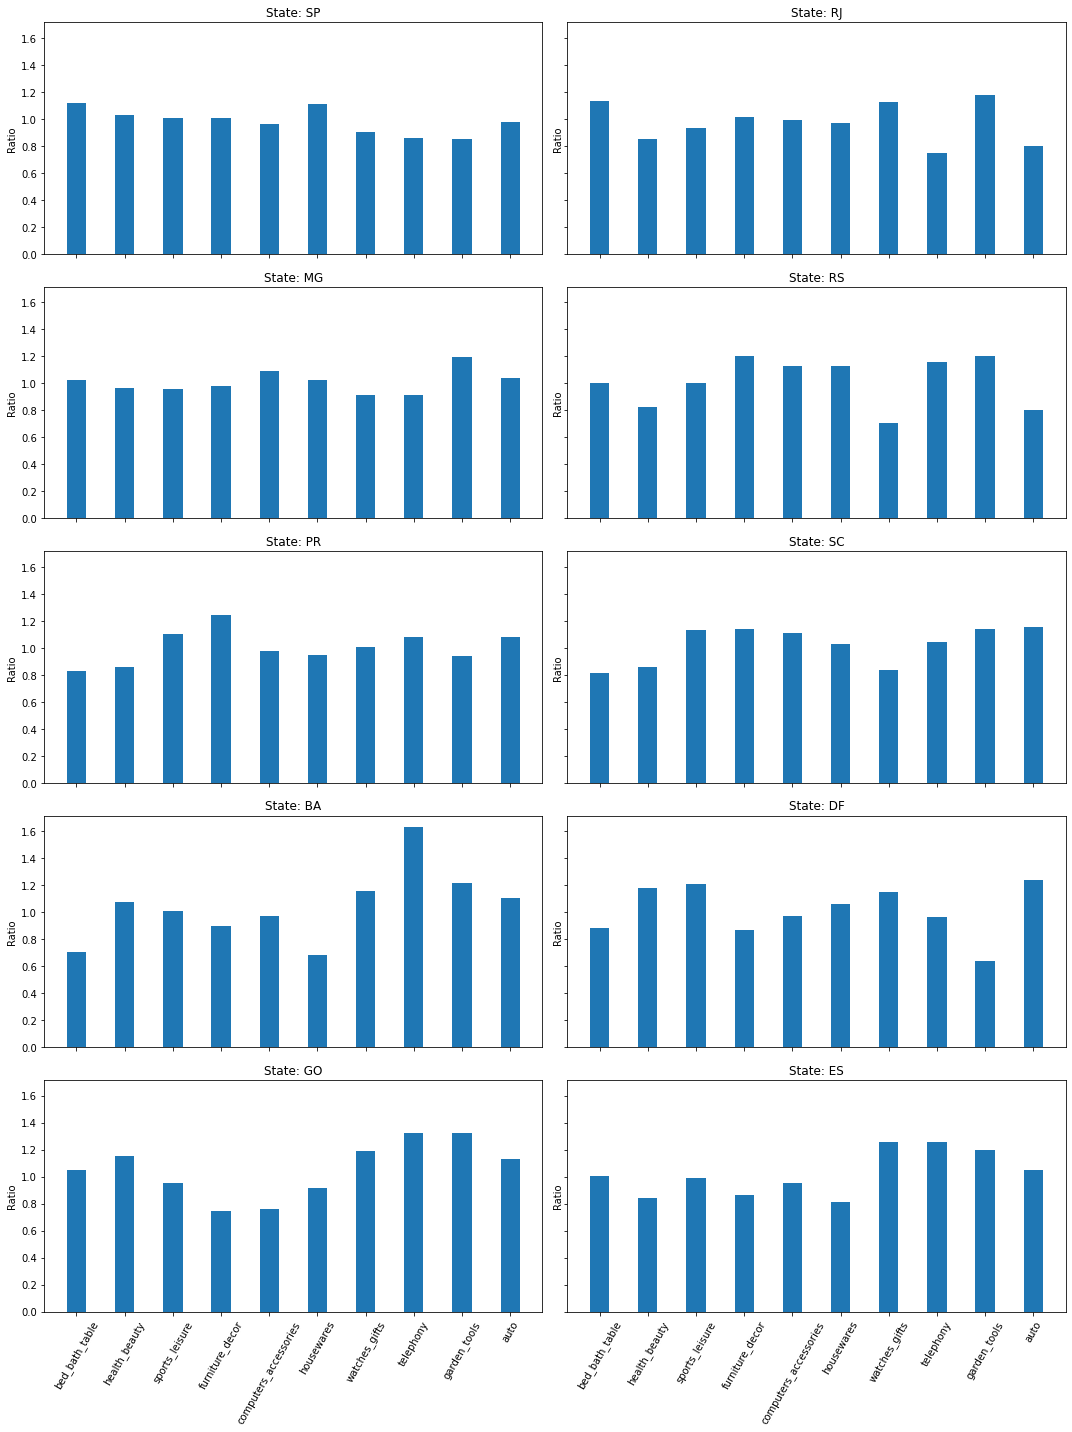

In [ ]:
f, ax = plt.subplots(5,2, sharex = True, sharey = True)
f.set_figheight(20)
f.set_figwidth(15)
for i,state in enumerate(state_comp_probs):
    axis = ax[i//2,i%2]
    axis.title.set_text("State: {}".format(state))
    axis.set_ylabel('Ratio')
    axis.bar(state_comp_probs[state].keys(),height=state_comp_probs[state].values(),width = 0.4)
    for tick in axis.get_xticklabels():
        tick.set_rotation(60)
f.tight_layout() 

The plots above show the ration of P(Category|State)/P(Category). When the ratio is equal 1 means that a purchase of the coresponding category occurs at the same level within a state as in the country as a whole. If the ratio is greater than 1 the purchases occurs more frequently within that state. When the ration is smaller than 1, the purchase within the state is less frequent than in the country as a whole.

From the plot above we observe that the ratio for every product within the top 10 product categories to be purchased in the top 10 states(states with more customers) ranges between 0.8 - 1.2 on average.

Overall we can see the frequency that a purchases occurs within each state for the top 10 selling categories.

For example, in BA we can see that a purchases from the telephony category is more frequent than the other states.


## Orders-Time

In this part we will investigate the distribution of the order in weekly, daily and hourly basis. The data contains only years from 2016-2018 thus it didn't considered valuable to include the yearly distribution.
This analysis will give us an idea when the orders were placed.

For matter of simplicity we will illustrate the top 10 categories

In [ ]:
recommender['order_time'] = recommender['order_purchase_timestamp'].dt.time  #get time

recommender['order_weekday'] = recommender['order_purchase_timestamp'].dt.day_name() #get weekday



### Orders distribution monthly basis

In [ ]:
import calendar

recommender['order_month'] = recommender['order_purchase_timestamp'].dt.month

recommender['order_month'] = recommender['order_month'].apply(lambda x: calendar.month_abbr[x])

recommender['order_month'] = recommender['order_month'].astype('category')
recommender['order_month'].cat.reorder_categories(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'], inplace = True, ordered = True)

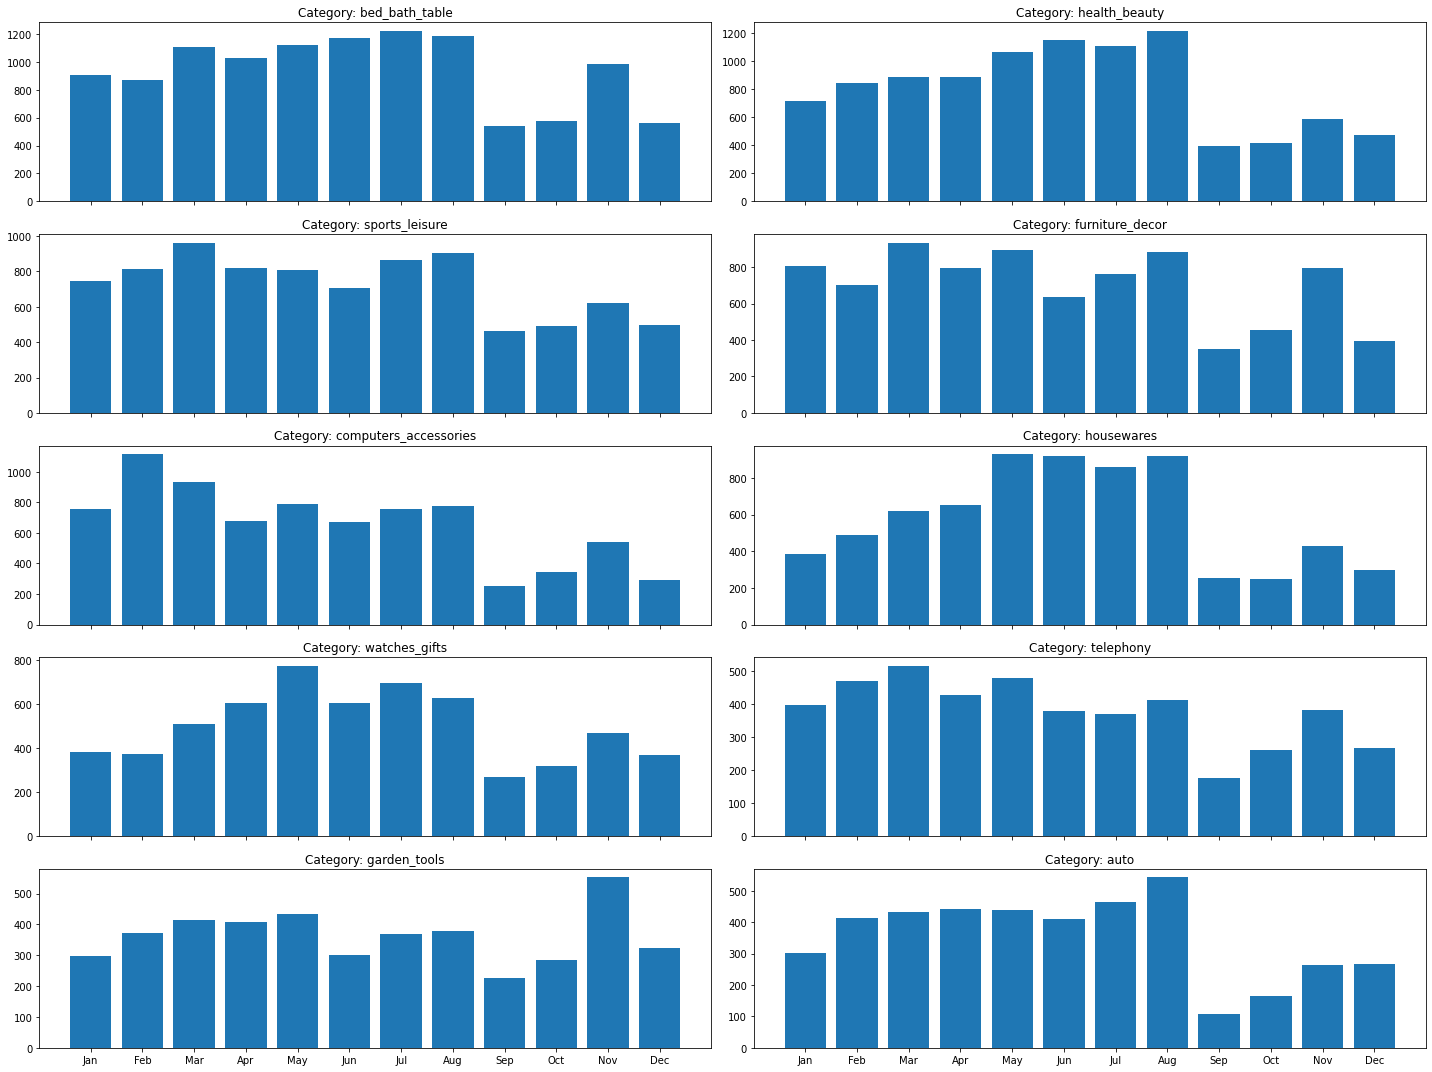

In [ ]:
#by month
f, ax = plt.subplots(5, 2, sharex = True)
f.set_figheight(15)
f.set_figwidth(20)
for i,cat in enumerate(focuscategories):
    axis = ax[i//2,i%2]
    by_month = recommender.loc[recommender['product_category_name_english'] == cat].order_month.value_counts()
    by_month.sort_index(inplace=True)
    axis.title.set_text("Category: {}".format(cat))
    axis.bar(by_month.keys(),height=by_month)
    
ax[0,0].title.set_text
    
f.tight_layout() 

On monthly basis the distribution of the orders varies from product categoy to product category.
We can observe as an overall pattern that months from September to December are slower in orders than for example the summer months.

### Distribution of order in weekly basis

In [ ]:
recommender['order_weekday'] = recommender['order_weekday'].astype('category')
recommender['order_weekday'].cat.reorder_categories(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'], inplace = True, ordered = True)

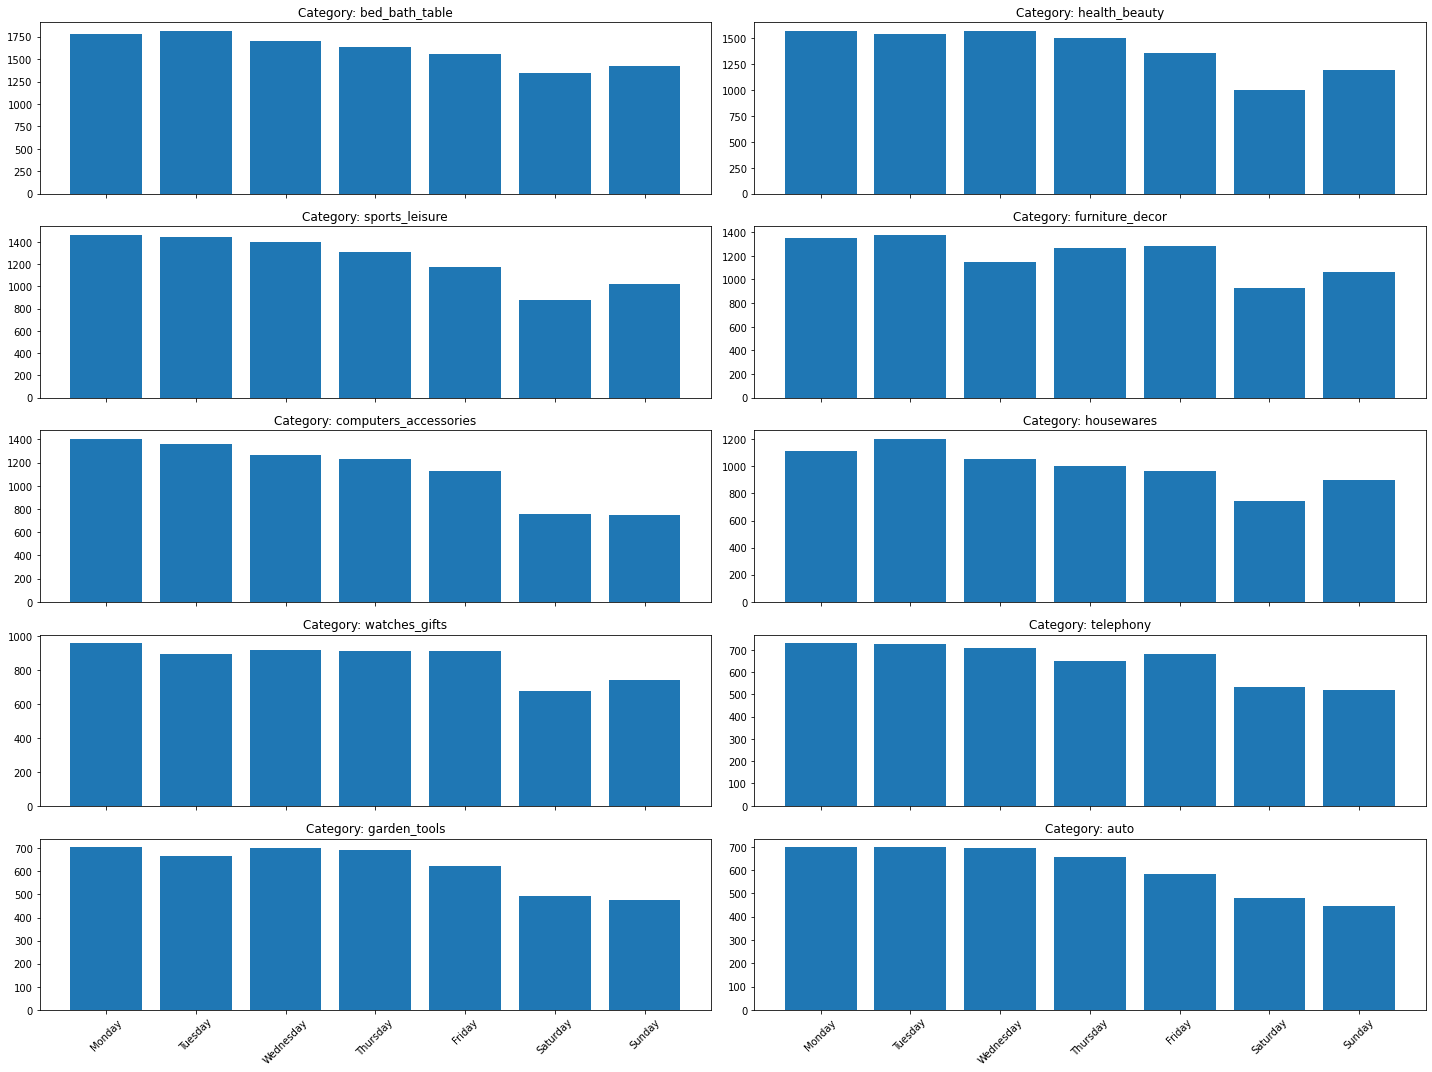

In [ ]:
#by week
f, ax = plt.subplots(5, 2, sharex = True)
f.set_figheight(15)
f.set_figwidth(20)
for i,cat in enumerate(focuscategories):
    axis = ax[i//2,i%2]
    by_week = recommender.loc[recommender['product_category_name_english'] == cat].order_weekday.value_counts()
    by_week.sort_index(inplace=True)
    axis.title.set_text("Category: {}".format(cat))
    axis.bar(by_week.keys(),height=by_week)
    axis.set_xticklabels(by_week.keys(), rotation=45)
    
ax[0,0].title.set_text
    
f.tight_layout() 

On daily basis, it is obvious that the order drop as we approach to the weekend. Saturday and Sunday are the days with the least amount of orders in all categories.

### Distribution of order in hourly basis

In [ ]:
recommender['order_hour'] = recommender['order_purchase_timestamp'].dt.hour


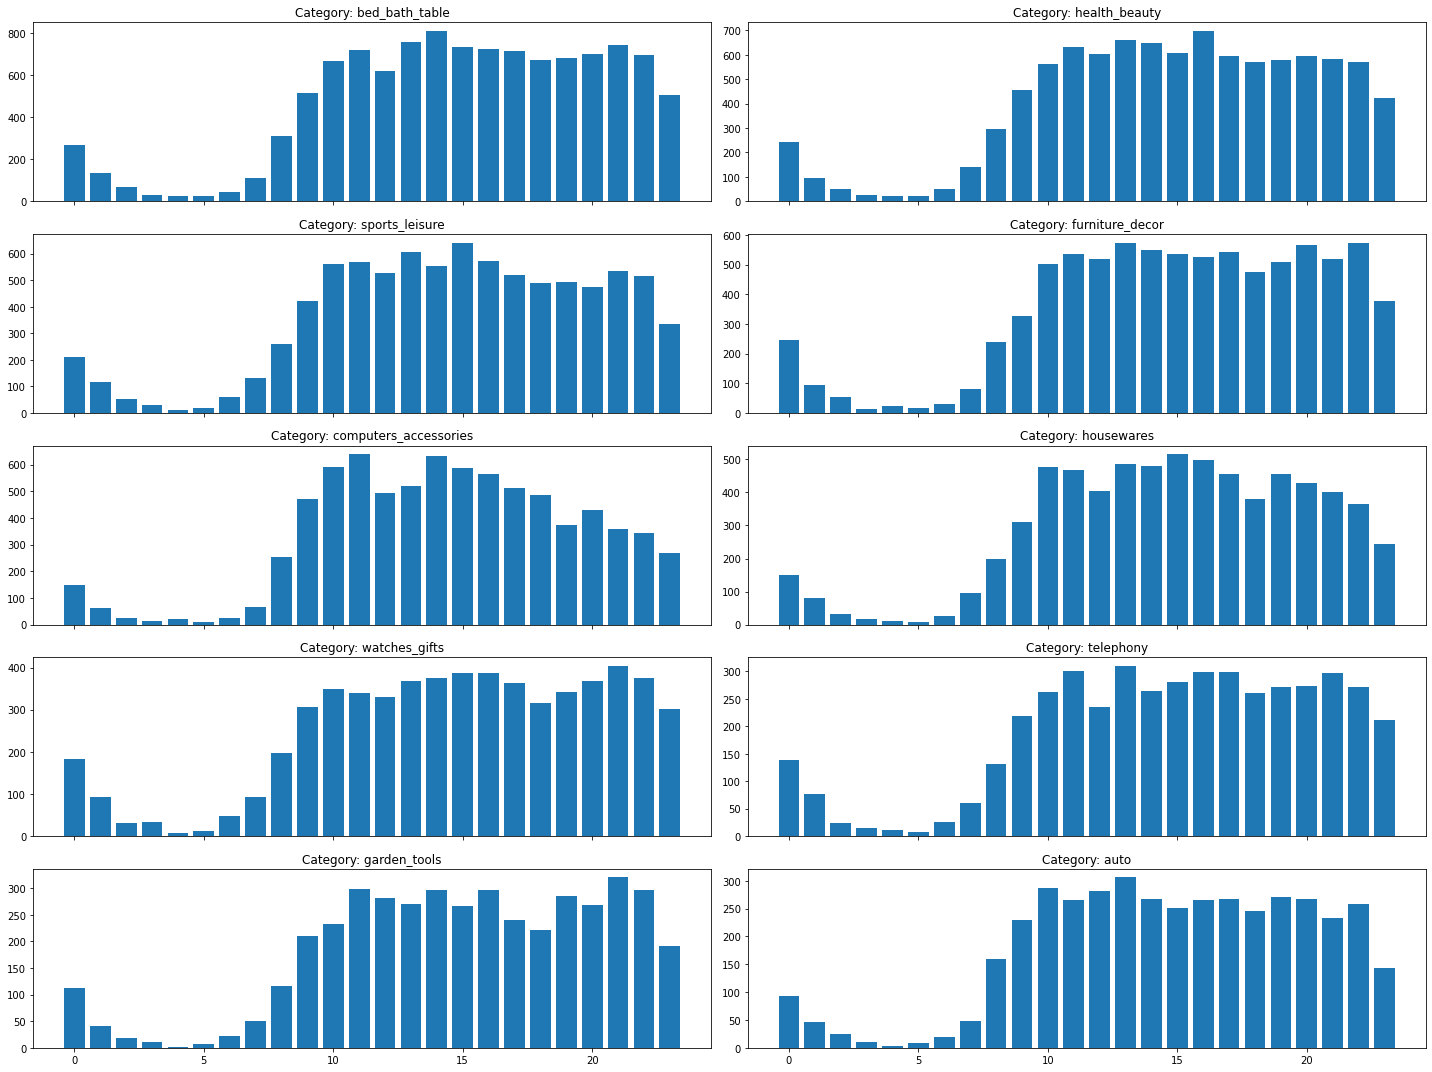

In [ ]:
#by_order hour

f, ax = plt.subplots(5, 2, sharex = True)
f.set_figheight(15)
f.set_figwidth(20)
for i,cat in enumerate(focuscategories):
    axis = ax[i//2,i%2]
    by_hour = recommender.loc[recommender['product_category_name_english'] == cat].order_hour.value_counts()
    by_hour.sort_index(inplace=True)
    axis.title.set_text("Category: {}".format(cat))
    axis.bar(by_hour.keys(),height=by_hour)
    
ax[0,0].title.set_text
    
f.tight_layout()

On hourly basis we observe that the busiest timeslot is between 10.00- 16.00 for all categories.
There is a small drop between 17.00 -18.00 and then orders increases again from 19.00 - 22.00 for the majority of the categories. For computer accessories the orders drop after 16.00 in the afternoon

In [ ]:
recommender = recommender.assign(hour_of_week = lambda x : x.order_purchase_timestamp.map(lambda y: y.dayofweek)*24 + x.order_hour)

The plot below summarizes the orders' distribution for every hour of the week for each of the focus products. The purpose is to get a better understanding on what hour for each day of the week an was placed.

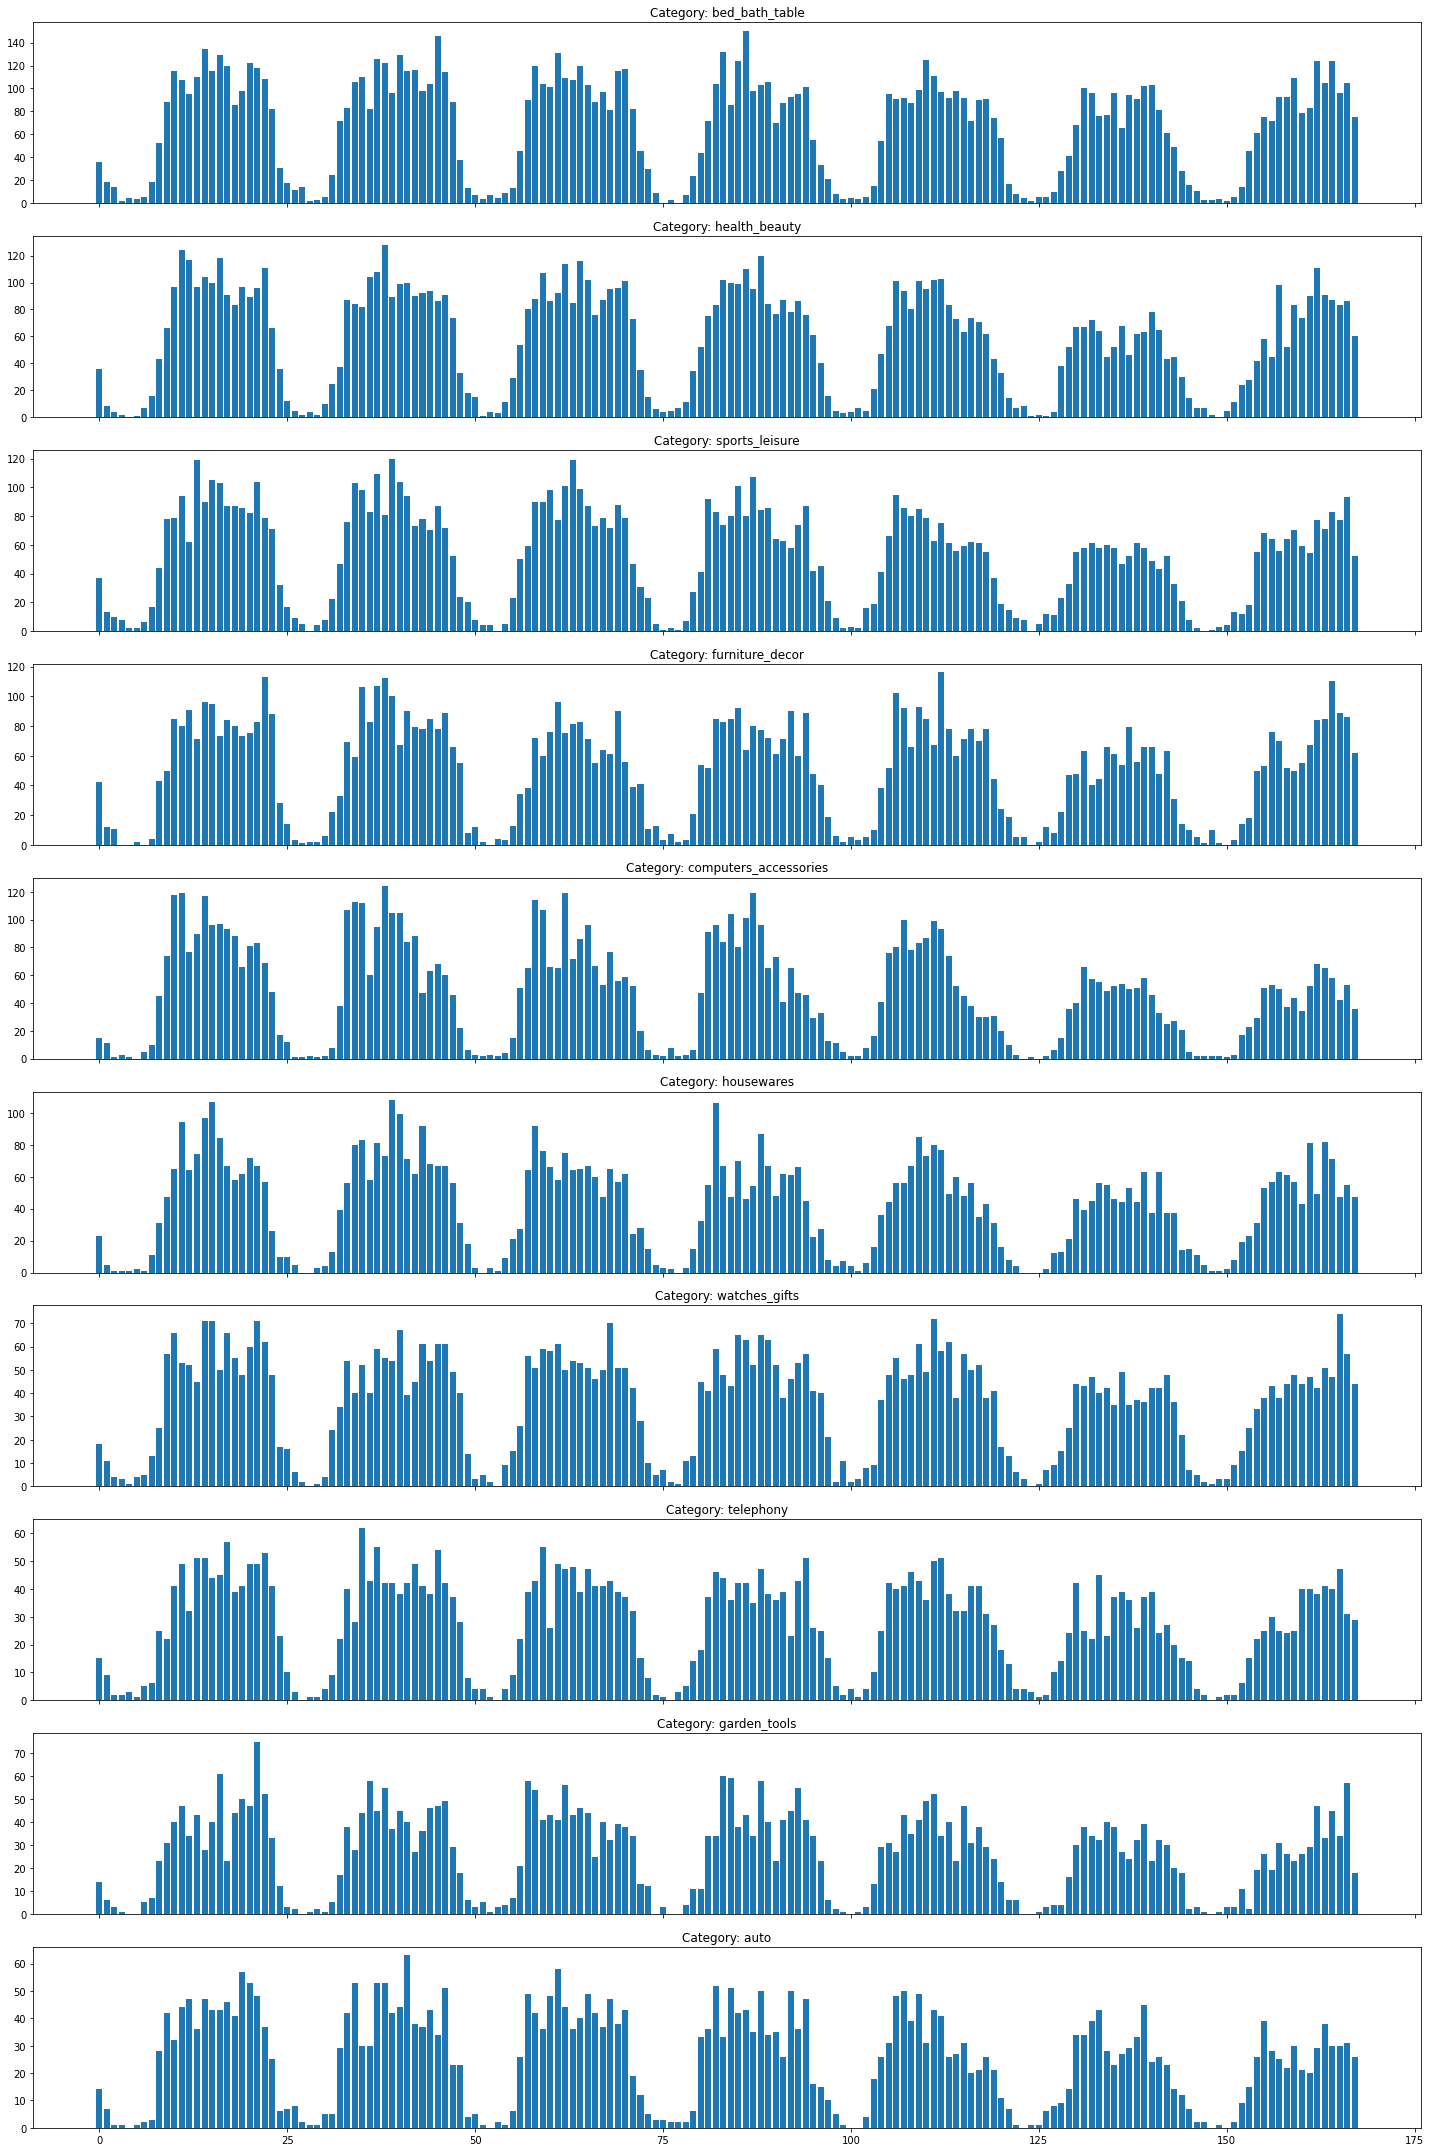

In [ ]:
#by_hour_of_week

f, ax = plt.subplots(10,1, sharex = True)
f.set_figheight(30)
f.set_figwidth(20)
for i,cat in enumerate(focuscategories):
    axis = ax[i]
    by_week_hour = recommender.loc[recommender['product_category_name_english'] == cat].hour_of_week.value_counts()
    by_week_hour.sort_index(inplace=True)
    axis.title.set_text("Category: {}".format(cat))
    axis.bar(by_week_hour.keys(),height=by_week_hour)
f.tight_layout() 


### Price Distribution of products

We would like to see the price distribution of the products. Therefore we categorize the products prices as Low, medium & High and created a new column as price_category.

In [ ]:
#Low
recommender['price_category'] = np.where(
   (recommender['price']>=0) & (recommender['price'] <=500) , 'Low', recommender['price'] 
   )
#Medium
recommender['price_category'] = np.where(
   (recommender['price']>=501) & (recommender['price'] <=2000) , 'Medium', recommender['price_category'] 
   )
#High
recommender['price_category'] = np.where(
   (recommender['price']>=2001) , 'High', recommender['price_category'] 
   )

In [ ]:
recommender.head()

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_purchase_timestamp,price,price_category
0,4,SP,SP,87285b34884572647811a353c7ac498a,housewares,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33,29.99,Low
1,4,SP,SP,87285b34884572647811a353c7ac498a,housewares,3a51803cc0d012c3b5dc8b7528cb05f7,2017-08-15 18:29:31,29.99,Low
2,5,SP,SP,87285b34884572647811a353c7ac498a,housewares,ef0996a1a279c26e7ecbd737be23d235,2017-08-02 18:24:47,29.99,Low
3,3,SC,SP,87285b34884572647811a353c7ac498a,housewares,e781fdcc107d13d865fc7698711cc572,2017-10-23 23:26:46,29.99,Low
4,1,SP,SP,be03d93320192443b8fa24c0ca6ead98,housewares,7a1de9bde89aedca8c5fbad489c5571c,2017-08-24 11:31:28,46.80,Low


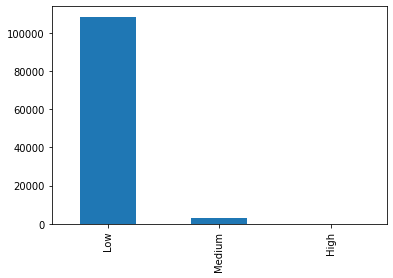

In [ ]:
recommender['price_category'].value_counts().plot(kind='bar')

We can clearly see that most of the products sold from 2016-2018 belongs to the Low price Category. Very few products belongs to the high price category.

# Conclusion

The exploratory analysis revealed that 75% of the products have gotten the top review scores.
The 34% of all the products sold from 2016 - 2018 included solely in four product categories out of 71 in total.

The state with the highest number of sellers and customers was the state of Sao Paolo where there is approximatelly 1.5 sellers per customers.
Also we saw what is the probability for a product to be purchased in each state.

With regards teh ordes distribution in monthly, daily and hourly basis different distributions observed across the product categories.

There are though few common patterns such as weekends are usually the slowest days during the week that a customer purchsed a product. Also summer months are busier than autumn and winter ones.
The busiest timeslots within a day that the orders purchased were from 10.00-16.00 and from 19.00 - 22.00.

Most of the products sold from 2016-2018 are cheap products.

The exploratory analysis depicted the attributes that are believed to be more relevant to build a recommender system upon.

The recommender system will be mainly based on the reviews customers provided to the products. However attribute such as location and time will be added further on in order to make the recommendation more precise.




## Final dataset

In [ ]:
recommender = recommender.drop(['order_purchase_timestamp','order_time','hour_of_week','order_date'],axis=1)

In [ ]:
recommender

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,price,order_weekday,order_month,order_hour
0,4,SP,SP,17106,housewares,45758,29.99,Monday,Oct,10
1,4,SP,SP,17106,housewares,21530,29.99,Tuesday,Aug,18
2,5,SP,SP,17106,housewares,87936,29.99,Wednesday,Aug,18
3,3,SC,SP,17106,housewares,85228,29.99,Monday,Oct,23
4,1,SP,SP,23951,housewares,44958,46.80,Thursday,Aug,11
...,...,...,...,...,...,...,...,...,...,...
111681,5,SP,SC,4599,la_cuisine,57240,112.00,Monday,Jan,17
111682,5,SC,SC,4599,la_cuisine,32279,105.00,Saturday,Jul,17
111683,5,SP,SC,22808,la_cuisine,40009,174.00,Saturday,Aug,19
111684,5,MG,SC,25855,la_cuisine,38842,129.00,Monday,Jul,18


Because it won't be very efficient to make the recommender system for each unique hour of the day. We will divide the order_hour in the following categories:\
Morning = 6.00 - 12.00\
Afternoon = 13.00 - 18.00\
Evening = 19.00 - 24.00\
Night = 1.00 -5.00


In [ ]:
#morning
recommender['day_category'] = np.where(
   (recommender['order_hour']>=6) & (recommender['order_hour'] <=12) , 'morning', recommender['order_hour']
   )
#afternoon
recommender['day_category'] = np.where(
   (recommender['order_hour']>=13) & (recommender['order_hour'] <=18) , 'afternoon', recommender['day_category']
   )
#evening
recommender['day_category'] = np.where(
   (recommender['order_hour']>=19) & (recommender['order_hour'] <=23) , 'evening', recommender['day_category']
   )

#night
recommender['day_category'] = np.where(
   (recommender['order_hour']>=0) & (recommender['order_hour'] <=5) , 'night', recommender['day_category']
   )
   

In [ ]:
recommender = recommender.drop(['order_hour'],axis=1)

In [ ]:
recommender

,review_score,customer_state,seller_state,product_id,product_category_name_english,customer_unique_id,order_weekday,order_month,day_category
0,4,SP,SP,17106,housewares,45758,Monday,Oct,morning
1,4,SP,SP,17106,housewares,21530,Tuesday,Aug,afternoon
2,5,SP,SP,17106,housewares,87936,Wednesday,Aug,afternoon
3,3,SC,SP,17106,housewares,85228,Monday,Oct,evening
4,1,SP,SP,23951,housewares,44958,Thursday,Aug,morning
...,...,...,...,...,...,...,...,...,...
111681,5,SP,SC,4599,la_cuisine,57240,Monday,Jan,afternoon
111682,5,SC,SC,4599,la_cuisine,32279,Saturday,Jul,afternoon
111683,5,SP,SC,22808,la_cuisine,40009,Saturday,Aug,evening
111684,5,MG,SC,25855,la_cuisine,38842,Monday,Jul,afternoon
